# WHAT'S COOKING?

## 1. Objective

The aim of the project is to develop a classification model that based on the recipes, predicts what cuisine a particular dish belongs to. This is a multi-class classification problem with 20 different class labels representing the cuisine, and inputs are comma separated words representing ingredients used for that particular dish. This project is inspired from a Kaggle competition and the data is taken from the same website. 

## 2. Data Description

The data consists of 39774 rows with the three columns as the following:

- **cuisine**: *string*, indicates the type of the cuisine
- **id**: *integer*, id corresponding to the restaurant
- **ingredients**: *string*, indicates the ingredients used by the cuisine

Each observation contains a string of ingredients and and a label which indicates the type of cuisine it belongs to.

In [21]:
data_train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


Distribution of cuisines in the data set is as follows:

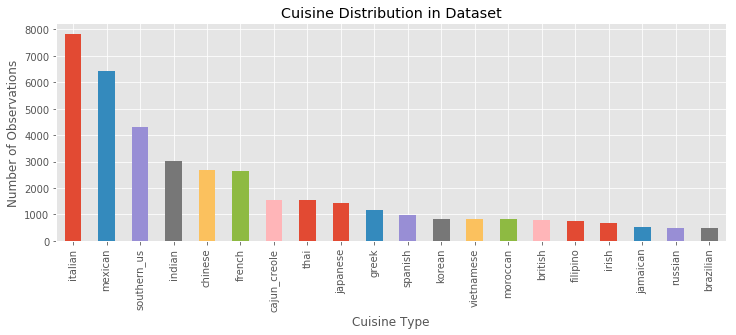

In [83]:
cuisine_dist = data_train['cuisine'].value_counts()
plt.figure(figsize=(12, 4))
cuisine_dist.plot(kind = 'bar')
plt.xlabel('Cuisine Type')
plt.ylabel('Number of Observations')
plt.title('Cuisine Distribution in Dataset')
plt.show()

### 2.1. Train and Test Datasets

Barplot above shows that the data set is significantly imbalanced with the majority of labels classified as *italian*, *mexican*, and *southern_us* and with a few *jamaican*, *russian*, and *brazilian*. Therefore, in order to divide the dataset into train (75%) and test (25%), the sampling is done in such a way that the proportionality among different cuisine types is remained unchanged in both train and test datasets **(Appendix 8.4)**.

## 3. Creating Structured Data

The problem in hand can be seen as a type of text mining problem, where using the words in the document we need to predict the title. Here, for example, document or recipe is a string of comma separated words or ingredients and we need to predict the title or the cuisine related to the dish. There are 2 ways to convert the document to features:

- Using CountVectorizer to convert the words to counts. Each feature represents a word, and each document has the count. Another extension of this approach would be to convert each feature to binary variables, thus if a recipe contains a word, it contains 1 otherwise 0.
- term frequency inverse document frequency (*tf-idf*)  vectorizer returns the normalized count based on how many times an ingredient appears in all the recipes.

## 4. Approach 1: tf-idf

For this approach, the `TfidfVectorizer()` function of the `sklearn.feature_extraction.text` library was used to create the features given the documents. To create the vocabulary, combination of one and two consequtive words were considered for each document. For example, let the document consist of - "Garlic paste", 3 words would be added to the vocabulary, namely, "garlic", "paste" and "garlic paste". Note that all the words are converted to small letters. Thus, using this approach, a total of 69808 features were obtained. To decrease the number of features further, two arguments - *max_features* and *max_df* were used. *max_features* limits the maximum number of features to be considered, and *max_df* discards all the features that have frequency larger than specified. To tune these parameters, a grid search using 3 fold cross-validation was used with the following parameter values:

- **max_features:** [500, 1500, 2500, 3500, 4500]
- **max_df:** [0.3, 0.4, 0.5, 0.6, 0.7]

A logistic regression model was developed with 'C'=1 and penalty = 'l2' to compare between different parameter values. The accuracy bar plot is shown below. After careful consideration, *max_features* and *max_df* were taken to be 1500 and 0.5, respectively.

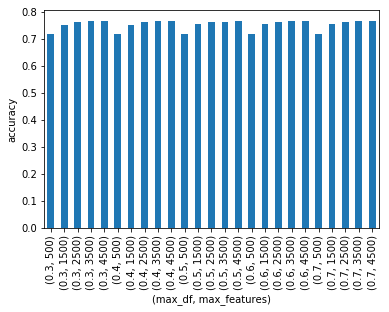

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
test_acc = pd.DataFrame.from_csv("F:/Old_Desktop/Machine Learning Projects/Loan Prediction/Python-20180611T063926Z-001/Python/test_acc_tfidf.dat")
ax = pd.Series(test_acc.iloc[:,0]).plot(kind = 'bar')
ax.set_xlabel("(max_df"+ ", "+"max_features)")
ax.set_ylabel("accuracy")

Using above parameter values, the filtered dataset is used for modeling. 
With the filtered features, the variables with 0 variance were removed. Following models were considered for this approach- logistic regression, SVM and XGBoost.

### 4.1. Logistic Regression and Support Vector Machines

The idea behind applying logistic regression was to develop a baseline model for further improvements. Two parameters - 'penalty' and 'C', were required to be tuned. An overview of these parameters is given as follows:
- **penalty:** There are 2 types of penalty that are widely used, 'l1' and 'l2'. These penalties shrink the coefficients of the variables in the models to prevent overfitting. The difference between 'l1' and 'l2' being that 'l1' shrinks the coefficients to exactly 0 unlike 'l2', hence, resulting in sparse models. Thus, 'l2' penalty is used for regularization, whereas, 'l1' penalty leads to feature selection.
- **C:** This is the regularization parameter. Higher the value, more the variables get shrinked, thus more the regularization. If value of C is put to zero, it simply leads to use of all the features in modeling without any regularization.

To tune these parameters, a 3 fold crossvalidation was used on the following grid of parameters:

- **C:** [0.001, 0.01, 0.1, 1, 10, 100]
- **penalty:** ['l1', 'l2']

The crossvalidation produced best results at *C* = 10 and *l2* penalty. The accuracy on testing set came out to be 0.763.

For SVMs, only linear kernels were used, because the number of features are already large, hence mapping the features to a larger dimension did not make much sense. To tune linear SVM, again, two parameters are needed to be tuned - *penalty* and *C* as explained above. Again, a three fold crossvalidation was used with the same grid values as logistic regression. For SVM, crossvalidation gives best accuracy with *C* = 1 and *l1* penalty. The accuracy did not improve much though, and came out to be 0.764. Next, a more complex model - XGBoost, is trained in order to improve the accuracy.

### 4.2. XGBoost

The XGBoost is a recently developed advanced version of gradient boosting algorithm and is short for Extreme Gradient Boosting. It has proved instrumental in improving the prediction accuracy in the past and was worth giving a shot for this project. XGBoost is more complex than logistic regression or svm as it has larger number of parameters to be tuned, namely - *learning rate*, *max_depth*, *min_child_weight*, *gamma*, *subsample*, *colsample_bytree*, *reg_alpha*, *reg_lambda* and *n_estimators*. A short description of these parameters and how to tune them is provided in the section(6.6).

Following the tuning procedure, the values of the parameters come out to be - *max_depth* = 3, *min_child_weight* = 3, *gamma* = 0, *subsample* = 0.8, *colsample_bytree* = 0.6, *reg_alpha* = 1, *reg_lambda* = 1e-1, *learning rate* = 0.05, and *n_estimators* = 852. 

The accuracy came out to be 0.772.

Thus, the best accuracy achieved so far is 0.772. Here, we reviewed our initial assumptions for selecting features using tf-idf approach, where selecting 1500 features from a large pool of features seems nasty. Thus, we decided to change the approach to count vectorizer, i.e., approach 2 as explained above.  

## 5. Approach 2: Count Vectorizer

Since the input space (ingredients) is string of words, it cannot be used directly in the machine learning (ML) models to predict the labels. In order to make the feature space ready to be used in different machine learning algorithms, we need numbers. One way that we can convert the string of words into numbers is using the bag of words techniques. The ingredients in the training data create the vocabulary. Each variate represent a word from the vocabulary, and the data set contains the count for each ingredient against each sample. With this approach, we ended up having 3010 columns of different words used in the ingredients **(Appendix 8.4)**.

Having such a big feature space with 3010 features will result in teremendous computational time that make it somehow impossible to train more sophisticated ML algorithms such as **Gradient Boosting** and **XGBoost** on local machines. Therefore, to overcome this issue we need to reduce feature space size by using dimensionality reduction techniques. In the following, two techniques employed to reduce the input space is explained.

### 5.1. Principle Component Analysis (PCA)

The first approach used to reduce the size of the feature space was PCA. We picked the first **1108** principle components which were responsible for the **99%** explained variance ratio in the dataset. Using the truncated principle components in a logistic regression algorithm, did not change the computational time as much, however, decreased the accuracy of the model considerably. 

The reason that can explain the insigfincance effect of PCA on computational time, eventhough it reduced the feature space by almost $\frac{1}{3}$, was due the the fact that PCA transforms the original feature space which contained binary variables to a space that contained continuous variables and as a result the computational time has not improved. This ineffectivenss is even more prominent in the tree-based algorithms such as Random Forest and Gradient Boosting that are known to train faster on categorical variables. Therefore, PCA failed to meet its goal which was improving the computational time by reducing the dimensionality reduction in this problem **(Appendix 8.5.1)**. 

### 5.2. Variance Threshold

The other technique that was used to reduce the dimensionality of the feature space was variance threshhold. In this technique, we discarded the features that did not pass a certain threshold (keeping more important features). The way that we specify this threshold was by using *cross validation* on logistic regression model accuracy **(Appendix 8.5.2)**. By training logistic regression for each truncated feature space corresponding to a specific variance threshold, we picked the variance that from that point on, the model accuracy does not change much and also it will be close the accuracy of full feature model. Figure below shows the scatter plot for this process. In this problem, we picked **1193** high variance features with threshhold **0.0005**. Using this teqnique, we keep the feature space binary while reducing the size which led to decrease the computational time significantly.

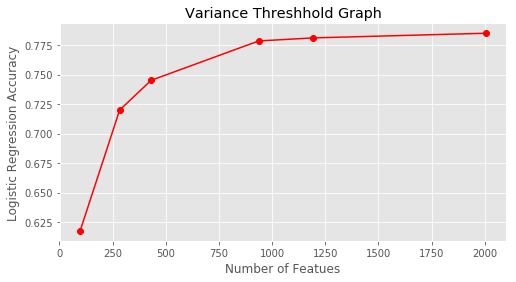

In [79]:
plt.figure(figsize=(8, 4))
plt.plot(feat_size, acc_list, 'ro-')
plt.xlabel('Number of Featues')
plt.ylabel('Logistic Regression Accuracy')
plt.title('Variance Threshhold Graph')
plt.show()

## 6. Models

### 6.1. Logistic Regression

To tune the parameters - *C* and *penalty*, a three fold cross validation was performed on the following parameter value grid:
- **C:** [0.001, 0.01, 0.1, 1, 10, 100]
- **penalty:** ['l1', 'l2']

The results for each combination are shown below. The best model chosen by the cross validation comes out to be with *C* = 1 and *penalty* = 'l2' **(Appendix 8.6)**. The accuracy comes out to be 0.782, much better than what the best model in *tf-idf* approach resulted in.

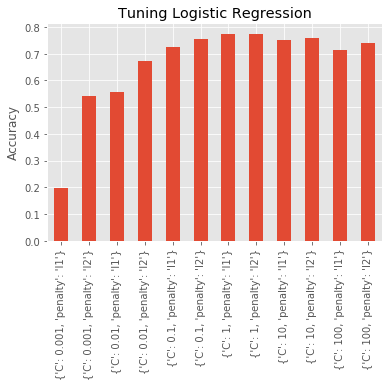

In [125]:
p_in = open("F:/Old_Desktop/Machine Learning Projects/Loan Prediction/Python-20180611T063926Z-001/Python/gcv_lr.pickle", "rb")
lr = pickle.load(p_in)
p_in.close()
ax = pd.Series(np.array(lr.grid_scores_)[:,1], np.array(lr.grid_scores_)[:,0]).plot(kind = 'bar')
ax.set_ylabel("Accuracy")
ax.set_title("Tuning Logistic Regression")

### 6.2. Linear/Quadratic Discriminant Analysis (LDA/QDA)

We performed both linear and quadratic discriminant analysis on the data **(Appendix 8.7)**. The LDA achieved an accuracy of 0.7370 and the QDA achieved an accuracy of 0.3364. There is a huge gap between the accuracies that could be an indication of linear relationship between predictors and response. This should be further investigated once more sophisticated models were performed.

### 6.3. Support Vector Machine (SVM)

Only linear kernel is considered for SVM because of large number of features in the dataset. To tune *C* and *penalty*, three fold cross validation is used for selecting the best parameter among the following grid values **(Appendix 8.8)**:
- **C:** [0.001, 0.01, 0.1, 1, 10, 100]
- **penalty:** ['l1', 'l2']

Cross validation results in *C* = 0.1 and *penalty* = 'l1' as the best parameters. The accuracy of SVMs remain at 0.782 on the test data. The bar plot of accuracy over the grid values is shown below.

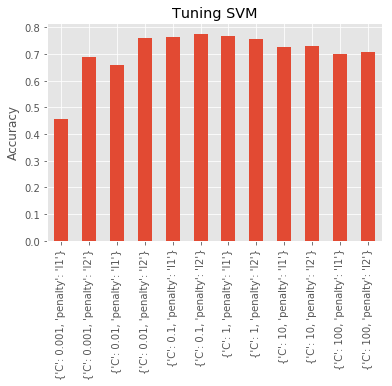

In [124]:
p_in = open("F:/Old_Desktop/Machine Learning Projects/Loan Prediction/Python-20180611T063926Z-001/Python/gcv_svm.pickle", "rb")
svm = pickle.load(p_in)
p_in.close()
ax = pd.Series(np.array(svm.grid_scores_)[:,1], np.array(svm.grid_scores_)[:,0]).plot(kind = 'bar')
ax.set_ylabel("Accuracy")
ax.set_title("Tuning SVM")

### 6.4. Random Forest

Another model that we will be exploring in this project is random forest. Random forest trains fairly fast on categorical data and in here we want to see if we can acheive an accuracy higher that what we have obtained so far by using logistic regression.

There are four parameters in random forest algorithms that should be tuned in order to obtain its maximum accuracy. These parameters are as following:

- **Number of trees:** The number of trees to be modeled. In random forest algorithm, normally more trees results in more accuracy. However this is not always the case and we will tune this paramter in the next section.
- **Min samples in each split:** Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting. It is used to control over-fitting.
- **Min Samples in each leaf:** Defines the minimum samples (or observations) required in a terminal node or leaf. It is used to control over-fitting.
- **Max features in each tree:** Normally the square root of the number of features works fine.

In the following sections, we wil go through the essential steps to tune these parameters.

#### 6.4.1. Initial Model

In this step, we fit a model with the default parameters defined in the `sklearn.ensemble.RandomForestClassifier()` function to have a sense of model accuracy without any tunning **(Appendix 8.9.1)**. Default values for the models parameters are:

- Number of trees: **10**
- Min samples in each split: **2**
- Min Samples in each leaf: **20**
- Max features in each tree: **auto**

The only parameter that has been changed in the initial model is min samples leaf which is set to 20 now. The default value for this paramter was 1 which led to an accuracy of 0.7021 on test data set. However, the accuracy on train data set was 0.9901 which shows the over-fitting issue. Therefore, in order to have a fair reference point to compare the tuned models  in the next sections, we changed the min samples leaf to 20 and as a result the test set accuracy became 0.6118 which is much less that the previous one but it is close to what the model accuracy on the train data set which shows that the overfitting issue has been taken care of.

#### 6.4.2. Tune Min Samples Split, Min Samples Leaf, and Max Features

Min samples split, min samples leaf, and max features are tree specific features. Therefore, the first step to tune the random forest algorithm is to tune these features. In order to avoid high computational time for tuning these parameters, we assume the number of trees to be 10. In the next section we will tune the number of trees based on the parameters we have obtained in this section.

We have considered a range between 5 to 50 with a step size of 10 for min samples leaf, a range between 10 to 100 with a step size of 10 for min samples split, and values of 35 (square root of total number of features), 120 (~0.1 of all features), 240 (~0.2 of all features), and 480 (~0.4 of all features) for max features **(Appendix 8.9.2)**. This grid sums up to 200 distinct combinations with implementing 5-CV fold will eventually ends up to 1000 models to fit.

In [57]:
#import RFsearch object
pickle_in = open('01RF_search1.pickle', 'rb')
RFsearch = pickle.load(pickle_in)
pickle_in.close()
acc = RFsearch.score(X_test_var, y_test, )
print('Model accuracy after tuning the parameters is: %.4f' %acc)

Model accuracy after tuning the parameters is: 0.6961


Plots below show the accuracy of the model by changing the tuning parameters. It can be seen that the highest accuracy of 0.6961 was acheived under:

- **Max feature:** 240
- **Min samples leaf:** 5
- **Min samples split:** 10

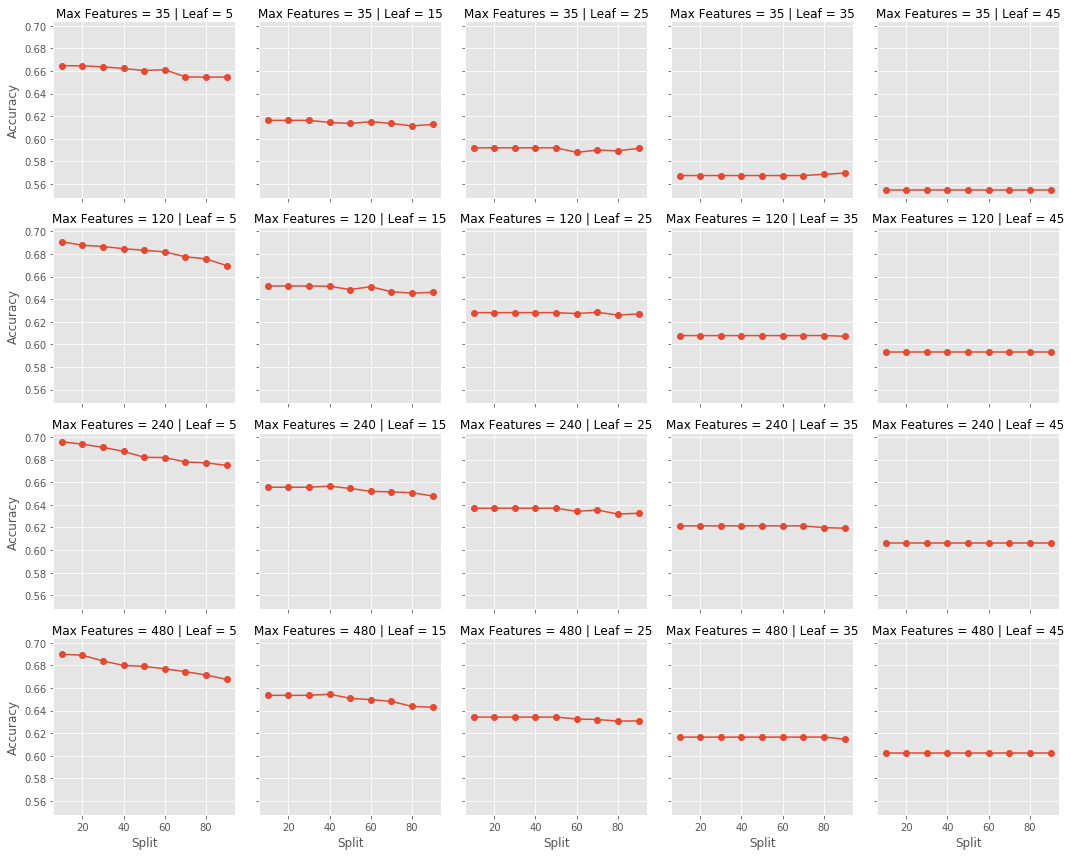

In [32]:
score = [x[1] for x in RFsearch.grid_scores_]
max_features = [x[0]['max_features'] for x in RFsearch.grid_scores_]
min_sample_split = [x[0]['min_samples_split'] for x in RFsearch.grid_scores_]
min_sample_leaf = [x[0]['min_samples_leaf'] for x in RFsearch.grid_scores_]
df = pd.DataFrame({'Max Features': max_features, 'Split': min_sample_split, 
                   'Leaf': min_sample_leaf, 'Accuracy': score})
plot = sns.FacetGrid(df, col="Leaf", row='Max Features')
plot = (plot.map(plt.plot, "Split", "Accuracy", marker='o'))

#### 6.4.3 Tune the Number of Trees

Now that we have tuned all the parameters in the model, we will be tuning the number of trees. Normally, in random forest, higher number of trees would give better accuracy as it leads to less variance in predictions. In this section we conider a set of 500, 1000, 1500 values for the number of trees **(Appendix 8.9.3)**.

In [55]:
#save the RFsearch2 object
pickle_in = open('02RF_search2.pickle', 'rb')
RFsearch2 = pickle.load(pickle_in)
pickle_in.close()
acc = RFsearch2.score(X_test_var, y_test)
print('Final model accuracy is: %.4f' %acc)

Final model accuracy is: 0.7165


Plot below shows that the random forest with 1500 trees has the highest accuracy. Also, the accuracy of the model on the test dataset was 0.7165 which has increased considerably compared to the initial model with accuracy 0.6961. 

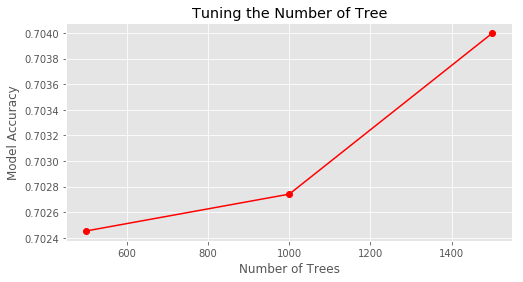

In [52]:
scores = [x[1] for x in RFsearch2.grid_scores_]
tree_num = RFsearch2.param_grid['n_estimators']
plt.figure(figsize=(8, 4))
plt.plot(tree_num, scores, 'ro-')
plt.xlabel('Number of Trees')
plt.ylabel('Model Accuracy')
plt.title('Tuning the Number of Tree')
plt.show()

### 6.5. Gradient Boosting

So far, none of the algorithms mentioned above could beat the accuracy obtained by logistic regression. There are two reasons that one could think of for this, one there is a linear relationship between the predictors and response that could be perfectly captured by logistic regression, or the models were not flexible enough to exceed the initial accuracy obtained by logistic regression. 

In this section and the following, we are performing much more sophisticated approaches in the hope of increasing the accuracy. These models have many parameters that should be tuned in order to reach their maximum capacity of learning. These features for gradient boosting algorithm are:

- **Number of trees:** The number of sequential trees to be modeled. Gradient boosting is more robust when the number of trees grows. This number should be chosen based on the learning rate.
- **Learning rate:** This determines the impact of each tree on the final outcome. Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.
- **Min samples in each split:** Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting. It is used to control over-fitting.
- **Max Depth of the tree:** The maximum depth of a tree. It is used to control over-fitting.
- **Min Samples in each leaf:** Defines the minimum samples (or observations) required in a terminal node or leaf. It is used to controll over-fitting.
- **Max features in each tree:** Normally the square root of the number of features works fine.

In the following, we will go through the essential steps to tune these parameters.

#### 6.5.1. Initial Model

In this step, we fit a model with the default parameters defined in the `sklearn.ensemble.GradientBoostingClassifier()` function to have a sense of model accuracy without any tunning **(Appendix 8.10.1)**. Default values for the models paramters are:

- Number of trees: **100**
- Learning rate: **0.1**
- Min samples in each split: **2**
- Max Depth of the tree: **3**
- Min Samples in each leaf: **1**
- Max features in each tree: **None**

In [15]:
#import GB_initial object
pickle_in = open('00GB_initial.pickle', 'rb')
GB_initial = pickle.load(pickle_in)
pickle_in.close()
acc = GB_initial.score(X_test_var, y_test)
print('Initial model accuracy is: %.4f' %acc)

Initial model accuracy is: 0.7520


Initial model accuracy without any tuning was ended up to be 0.752 which was much less that what we obtained from logistic regression with accuracy 0.782. We need to tune the gradient boosting paramters to increase its accuracy.

#### 6.5.2. Tune Number of Trees

The first parameter that we have to tune in the first step is the number of trees. As mentioned earlier, one factor that affects the number of trees is the learning rate. It means the higher learning rate results in lower number of trees needed. Also, we should consider the fact that if we tune the number of trees to higher numbers at this stage, lets say something more that 100, this will cost us a huge computational time for tuning the other paramters coming up in the next sections, as we have to tune a gradient boosting that has too many trees. Therefore, in this section we defined a high learing rate for the model, which is 0.3, in order to bring the optimum number of trees to 80 **(Appendix 8.10.2)**. We are confident, once we tune all the parameters in the model, we can eventually decrease the learning rate and increase the number of trees proportionally in order to acheive a much more robust and stable model with higher accuracy.

To tune the number of trees, we considered a range between 50 to 100 with a step of 10 and the following assumptions for the rest the parameters. It should be noted that the other parameters will be tuned in the next steps, so the values assumed for this part are temporary.

- Number of trees: **[50, 60, 70, 80, 90, 100]**
- Learning rate: **0.3**
- Min samples in each split: **200**
- Max Depth of the tree: **8**
- Min Samples in each leaf: **50**
- Max features in each tree: **sqrt**

In [17]:
#import GBsearch object
pickle_in = open('01gbsearch_n_estimator.pickle', 'rb')
GBsearch = pickle.load(pickle_in)
pickle_in.close()
acc = GBsearch.score(X_test_var, y_test)
print('Model accuracy after tuning the number of trees is: %.4f' %acc)

Model accuracy after tuning the number of trees is: 0.7594


We used the cross validation with 5 folds to calculate the accuracy of the model. The best accuracy we obtained was 0.7594 with a model with **80** trees. we can see that the model accuracy increased by 0.007 from the initial model. The following plot shows the model accuracy for each number of trees:

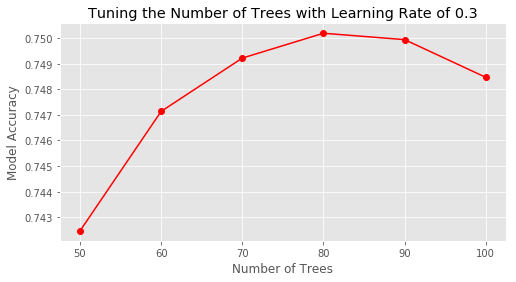

In [86]:
scores = [x[1] for x in GBsearch.grid_scores_]
tree_num = GBsearch.param_grid['n_estimators']
plt.figure(figsize=(8, 4))
plt.plot(tree_num, scores, 'ro-')
plt.xlabel('Number of Trees')
plt.ylabel('Model Accuracy')
plt.title('Tuning the Number of Trees with Learning Rate of 0.3')
plt.show()

#### 6.5.3. Tune Maximum Depth and Min Samples Split

Among the parameters that should be tuned for gradient boosting algorithm, maximum depth and min samples split have higher impact on the result of the model and hence they are tuned first. We have considered a range between 2 to 14 with a step size of 2 for max depth and a range between 200 to 1400 with a step size of 200 for min samples split **(Appendix 8.10.3)**. This grid sums up to 49 distinct combinations with implementing 5-CV fold will eventually ends up to 245 models to fit.

In [87]:
#import GBsearch2 object
pickle_in = open('02gbsearch_depth_minSample.pickle', 'rb')
GBsearch2 = pickle.load(pickle_in)
pickle_in.close()
acc = GBsearch2.score(X_test_var, y_test)
print('Model accuracy after tuning the maximum depth and min samples split is: %.4f' %acc)

Model accuracy after tuning the maximum depth and min samples split is: 0.7582


Plots below show the model accuracy for each min samples split with different max depth. It could be seen that model with min samples 1000 and max depth of 14 had the highest accuracy among all the models. It was obvious that the model has the increasing trend and maybe adding more depth and min samples split may have increased the accraucy. However, since implementing these many models with 5-fold cross validation takes a long time (8~10 hours) we decided to keep the current numbers and continue to tune the rest of paramters based on these. Of course we could have tweaked the number more in order to increase the accuracy. The accuracy we obtained from this model was 0.7582 which was slightly lower that the previous part but as mentioned due to time constraint we proceed with these numbers.

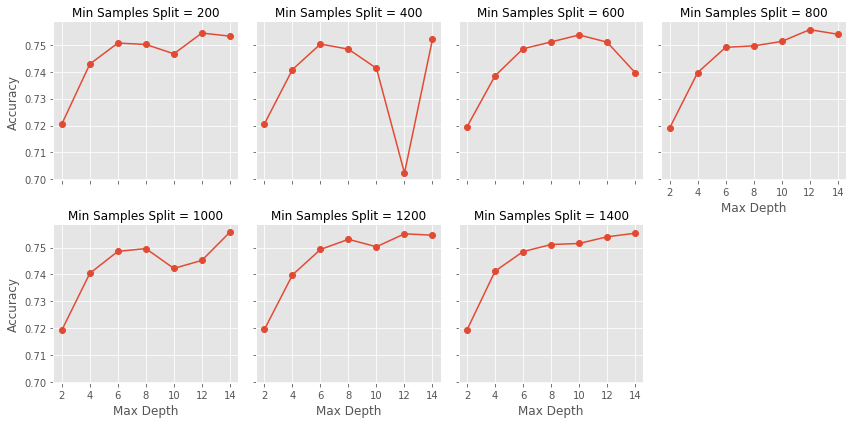

In [140]:
score = [x[1] for x in GBsearch2.grid_scores_]
max_depth = [x[0]['max_depth'] for x in GBsearch2.grid_scores_]
min_sample_split = [x[0]['min_samples_split'] for x in GBsearch2.grid_scores_]
df = pd.DataFrame({'Max Depth': max_depth, 'Min Samples Split': min_sample_split, 'Accuracy': score})
plot = sns.FacetGrid(df, col="Min Samples Split", col_wrap=4)
plot = (plot.map(plt.plot, "Max Depth", "Accuracy", marker='o')).set(xticks=range(2, 15, 2))

#### 6.5.4. Tune Min Samples Leaf and Max Features

In this section we are performing the same method that we did in previous sections to tune the min samples leaf and max features parameters. These numbers affacts the over-fitting and should be tuned carefully. We have considered 35 (square root of total number of features), 120 (~0.1 of all features), and 240 (~0.2 of all features) for max features and 50, 70, and 120 for min samples leaf **(Appendix 8.10.4)**. Of course, in order to get more precise results, one could consider more combinations but due to high computational time we only considered these numbers. 

In [88]:
#import GBsearch3 object
pickle_in = open('03gbsearch_features_minLeaf.pickle', 'rb')
GBsearch3 = pickle.load(pickle_in)
pickle_in.close()
acc = GBsearch3.score(X_test_var, y_test)
print('Model accuracy after tuning the min samples leaf and max features is: %.4f' %acc)

Model accuracy after tuning the min samples leaf and max features is: 0.7710


Plots below show the model accuracy for different combinations of max features and min samples leaf. The best accuracy was obtained by max features of 240 and min samples split of 50. The accuracy for this model was 0.7710 which shows a great increase in accuracy compared to the previous models.

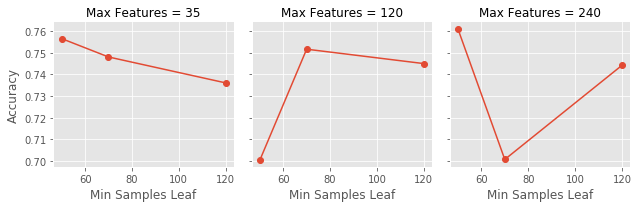

In [145]:
score = [x[1] for x in GBsearch3.grid_scores_]
max_features = [x[0]['max_features'] for x in GBsearch3.grid_scores_]
min_sample_leaf = [x[0]['min_samples_leaf'] for x in GBsearch3.grid_scores_]
df = pd.DataFrame({'Max Features': max_features, 'Min Samples Leaf': min_sample_leaf, 'Accuracy': score})
plot = sns.FacetGrid(df, col="Max Features", col_wrap=3)
plot = (plot.map(plt.plot, "Min Samples Leaf", "Accuracy", marker='o'))

#### 6.5.5. Final Model with Low Learning Rate and High Number of Trees

Now that we have tuned all the paramters in the model, we will be decreasing the learning rate to 0.01 and the number of trees to 2400 in order to increase the accuracy and build a more stable and robust model **(Appendix 8.10.5)**. The final model accuracy was 0.7897 which shows a huge improvement compared to the intial model without any tuning with an accuracy of 0.7594. Also, the final gradient boosting model outperformed the result we obtained from the logistic regression. 

In the next section we will explore the XGBoost algorithm and try to tune it to see if we can improve the accuracy even more!

In [91]:
#import GBsearch3 object
pickle_in = open('04GBfinal.pickle', 'rb')
GBfinal = pickle.load(pickle_in)
pickle_in.close()
acc = GBfinal.score(X_test_var, y_test)
print('Final Model accuracy after decreasing the learning rate and increasing the number of trees is: %.4f' %acc)

Final Model accuracy after decreasing the learning rate and increasing the number of trees is: 0.7897


### 6.6. XGBoost

The parameters required to tune in XGBoost are described below:
- *learning rate* : Makes the model more robust by shrinking the weights on each step
- *max_depth* : The maximum depth of each tree. Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
- *min_child_weight* : Minimum sum of weights of all observations required in a child. Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree
- *gamma* : A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split
- *subsample* : Fraction of observations to be randomly samples for each tree. Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting
- *colsample_bytree* : Fraction of columns to be randomly samples for each tree
- *reg_alpha* : L1 regularization term on weight
- *reg_lambda* : L2 regularization term on weights
- *n_estimators* : number of trees to ensamble

To tune these parameters, a step wise approach was followed, tuning the more important parameters first. The approach goes as follows:

- Use 0.2 as the learning rate. Tune max_depth and min_child_weight 
- Using the above optimized values of max_depth and min_child_weight, tune gamma
- Using the above optimized values, tune subsample and colsample_bytree 
- Using the all the above tuned parameters, tune reg_alpha and reg_lambda 
- Finally, decrease the learning to 0.1, then 0.05, to ensamble more trees

Thus, we go step by step tuning the parameters as follows:

#### 6.6.1 Tuning max_depth and min_child_weight 

The following values of max_depth and min_child_weight are considered for training the model **(Appendix 8.11.1)**. The accuracy on test set is compared.
- *max_depth* : range(1,16,2)
- *min_child_weight* : range(1,6,2)

The accuracy on the test set is depicted in the following plots. The best value of these parameters came out to be 13 for *max_depth* and 1 for *min_child_weight*. The accuracy comes out to be 0.797.

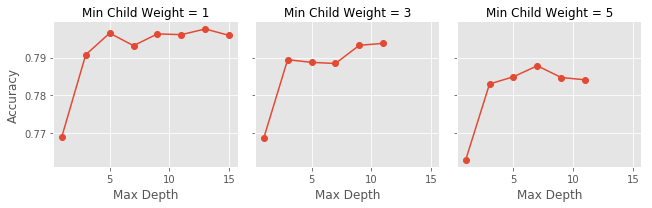

In [53]:
df = np.load("F:/Old_Desktop/Machine Learning Projects/Loan Prediction/Python-20180611T063926Z-001/Python/depthchild_acc_dishes.npy")
plt.style.use('ggplot')
plot = sns.FacetGrid(df_dmin, col = "Min Child Weight", col_wrap = 4)
plot = plot.map(plt.plot, "Max Depth", "Accuracy", marker = 'o')

#### 6.6.2 Tuning gamma

The following values of *gamma* are used for training the model **(Appendix 8.11.2)**. For *max_depth* and *min_child_weight*, the above tuned values are used.
- *gamma* : [0,0.1,0.2,0.3,0.4,0.5,0.6]
The accuracy on the test set in depicted below. The best value of *gamma* comes out to be 0.4. The accuracy comes out to be 0.801.

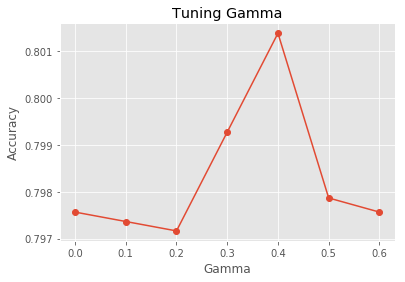

In [102]:
df_2 = pd.DataFrame.from_csv("F:/Old_Desktop/Machine Learning Projects/Loan Prediction/Python-20180611T063926Z-001/Python/gamma_acc_dishes.csv")
df_2 = pd.DataFrame({'Accuracy': list(df_2.index), 'gamma' : df_2.iloc[:,0]})
plt.plot(df_2.iloc[:,1], df_2.iloc[:,0], 'o-')
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
plt.title("Tuning Gamma")

#### 6.6.3 Tuning subsample and colsample_bytree

The following parameter values are considered for *subsample* and *colsample_bytree* to create a grid for training the model **(Appendix 8.11.3)**. The values of *max_depth*, *min_child_weight* and *gamma* are taken from the previous tuning steps. 
- *subsample* = [0.4, 0.6, 0.8, 1]
- *colsample_bytree* = [0.4, 0.6, 0.8, 1]

The plots for accuracy on test set for each grid value is shown below. For the best model the parameter values come out to be 0.8 for both *subsample* and *colsample_bytree*. The accuracy comes out to be 0.803

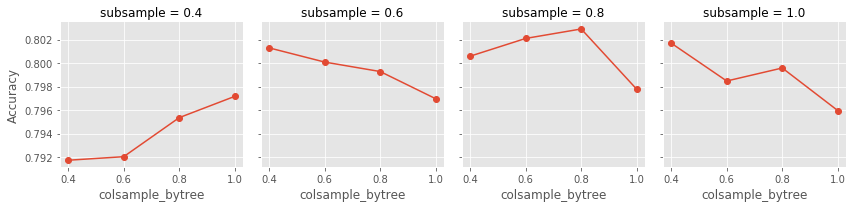

In [111]:
df_3 = pd.DataFrame.from_csv("F:/Old_Desktop/Machine Learning Projects/Loan Prediction/Python-20180611T063926Z-001/Python/colsamp_acc_dishes.csv")
df_3 = pd.DataFrame({'Accuracy': list(df_3.index), 'subsample' : df_3.iloc[:,0], 'colsample_bytree': df_3.iloc[:,1]})
plot = sns.FacetGrid(df_3, col = "subsample", col_wrap = 4)
plot = plot.map(plt.plot, "colsample_bytree", "Accuracy", marker = 'o')

#### 6.6.4. Tuning reg_alpha and reg_lambda

For tuning *reg_alpha* and *reg_lambda*, the following values are considered to create a grid for training the model **(Appendix 8.11.4)**. The values of *max_depth*, *min_child_weight*, *gamma*, *subsample*, and *colsample_bytree* are used from the above tuning results.
- reg_alpha = [0.01, 0.1, 1, 100]
- reg_lambda = [0.01, 0.1, 1, 100]

The plots for accuracy for each grid value are shown below. The best parameter values chosen are 0 for *reg_alpha* and 1 for *reg_lambda*. The accuracy after tuning these parameters does not change much and remain at 0.803.

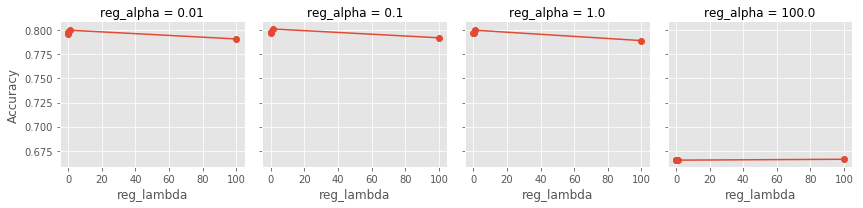

In [118]:
plot = sns.FacetGrid(df_4, col = "reg_alpha", col_wrap = 4)
plot = plot.map(plt.plot, "reg_lambda", "Accuracy", marker = 'o')

#### 6.6.5 Decreasing the learning rate

Finally, as all the above parameters are tuned, we decrease the learning rate and allow more trees to be trained and contribute to the ensamble **(Appendix 8.11.5)**. This leads to gradual approach towards optimality and results in increment of accuracy with decreased overfitting. Finally, the accuracy of xgboost for this approach comes out to be 0.804, that is great improvement from the accuracy we got from the previous approach.

## 7. Conclusion

We approached the problem in two ways, i.e., *tf-idf* and *count vectorizer* methods for creating the feature space. *tf-idf* method created a large pool of features, and filtering relevant features did not turn as successful as compared to the *count vectorizer* method. The reason for better performance of *count vectorizer* method could be the fact that the feature space obtained was less complicated. Thus, a simple logistic regression model for *count vectorizer* approach outperformed the best model of the *tf-idf* method. 

For the *Count Vectorizer* method, the performance of the models was found out to be in the following order:
- XGBoost - 80.42%
- Gradient Boosting - 78.96%
- SVM ~ Logistic Regression - 78.24%
- LDA - 73.70%
- Random Forest - 71.65%
- QDA - 33.64% 

## 8. Appendix

### 8.1. Import Packages

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import pickle
import time
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### 8.2. Read Data

In [8]:
data_train = pd.read_json('./train.json')

### 8.3. Preprocessing

In [9]:
le = LabelEncoder()
le.fit(data_train['cuisine'])
data_train['cuisine'] = le.transform(data_train['cuisine'])

In [10]:
ingredient_list = []
for row in data_train['ingredients']:
    ingredient = ' '.join(row)
    ingredient_list.append(ingredient)

### 8.4. Vectorizing the Ingredients and Splitting the Data

In [11]:
vectoizer = CountVectorizer()
ingredients = vectoizer.fit_transform(ingredient_list).todense()
ingredients = pd.DataFrame(ingredients)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(ingredients, data_train['cuisine'], test_size=0.3, 
                                                    random_state=10, stratify = data_train['cuisine'] )

### 8.5. Dimensionality Reduction Techniques

#### 8.5.1. Principle Component Analysis

In [38]:
#picking number of components that explain 99% of variablity
pca = PCA()
pca.fit(X_train, y_train)
var_exp_99 = np.where(np.cumsum(pca.explained_variance_ratio_)>=0.99)[0][0]
print('First %d principle components describe 99%% variability in the dataset!' %var_exp_99)

First 1108 principle components describe 99% variability in the dataset!


#### 8.5.2. Variance Threshhold

In [77]:
#cross validation to find the right variance threshhold
lr = LogisticRegression()
thresh_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
feat_size = []
acc_list = []
for thresh in thresh_list:
    selector = VarianceThreshold(threshold=thresh)
    selector.fit(X_train)
    X_train_var = selector.transform(X_train)
    X_test_var = selector.transform(X_test)
    feat_size.append(X_train_var.shape[1])
    lr.fit(X_train_var, y_train)
    acc = lr.score(X_test_var, y_test)
    acc_list.append(acc)

In [14]:
#picking high variance features
selector = VarianceThreshold(threshold=0.0005)
selector.fit(X_train)
X_train_var = selector.transform(X_train)
X_test_var = selector.transform(X_test)

### 8.6. Logistic Regression

In [ ]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
gcv_lr = GridSearchCV(LogisticRegression(dual = False).fit(X_tr, y_train), param_grid=params, cv = 3, 
                      verbose=True, iid=False, n_jobs=4).fit(X_tr, y_train)
print(gcv_lr.best_params_)
print(gcv_lr.score(X_tr, y_train))
print(gcv_lr.score(X_te, y_test))

### 8.7. LDA/QDA

In [47]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_var, y_train)
acc = lda.score(X_test_var, y_test)
print('Model accuracy is: %.4f' %acc)

Model accuracy is: 0.7370


In [48]:
qda = QuadraticDiscriminantAnalysis()
qda = qda.fit(X_train_var, y_train)
acc = qda.score(X_test_var, y_test)
print('Model accuracy is: %.4f' %acc)

Model accuracy is: 0.3364


### 8.8. SVM

In [ ]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
gcv_svc = GridSearchCV(LinearSVC(dual = False).fit(X_tr, y_train), param_grid=params, cv = 3, 
                      verbose=True, iid=False, n_jobs=4).fit(X_tr, y_train)
print(gcv_svc.best_params_)
print(gcv_svc.score(X_tr, y_train))
print(gcv_svc.score(X_te, y_test))

### 8.9. Random Forest

#### 8.9.1. Initial Model

In [46]:
#intial "random forest model"
rf = RandomForestClassifier(random_state=10, n_jobs=-1, min_samples_leaf=20)
rf.fit(X_train_var, y_train)
acc_test = rf.score(X_test_var, y_test)
print('Initial model accuracy is: %.4f' %acc_test)

Initial model accuracy is: 0.6118


#### 8.9.2. Tune Max Features, Min Samples Leaf, and Min Samples Split

In [ ]:
#tune the max_features, min_samples_leaf, min_samples_split
param_test = {'max_features': [35, 120, 240, 480], 'min_samples_leaf':range(5, 51, 10), 'min_samples_split':range(10, 100, 10)}
RFsearch = GridSearchCV(estimator = RandomForestClassifier(n_estimators=10,
                                                           random_state=10, verbose=1, n_jobs=-1), 
param_grid = param_test, scoring='accuracy',n_jobs=-1,iid=False, cv=5, verbose = 1)
RFsearch.fit(X_train_var, y_train)

#### 8.9.3. Tune the Number of Trees

In [ ]:
#tune the number of trees
param_test2 = {'n_estimators': [100, 500, 1000, 1500, 2000]}
RFsearch2 = GridSearchCV(estimator = RandomForestClassifier(max_features=RFsearch.best_params_['max_features'],
                                                            min_samples_leaf=RFsearch.best_params_['min_samples_leaf'],
                                                            min_samples_split=RFsearch.best_params_['min_samples_split'],
                                                           random_state=10, verbose=1, n_jobs=-1), 
param_grid = param_test2, scoring='accuracy',n_jobs=-1,iid=False, cv=5, verbose = 1)
RFsearch2.fit(X_train_var, y_train)

### 8.10. Gradient Boosting

#### 8.10.1. Initial Model

In [ ]:
#initial gradient boosting model without tuning
GB_initial = GradientBoostingClassifier(verbose=1, random_state=10)
GB_initial.fit(X_train_var, y_train)

#### 8.10.2. Tune Number of Trees

In [ ]:
#tune the number of trees
param_test1 = {'n_estimators':range(50,101,10)}
GBsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.3, min_samples_split=200,
                                                              min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                              subsample=0.8,random_state=10, verbose = 1), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=5, verbose = 1)
GBsearch.fit(X_train_var, y_train)

#### 8.10.3. Tune Maximum Depth and Min Samples Split

In [ ]:
#tune the "max depth" and "min_samples_split"
param_test2 = {'max_depth':range(2,15,2), 'min_samples_split':range(200,1401,200)}
GBsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.3, 
                                                                n_estimators=GBsearch.best_params_['n_estimators'], 
                                                                max_features='sqrt', 
                                                               min_samples_leaf=50, 
                                                                subsample=0.8, random_state=10, verbose=1), 
param_grid = param_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5, verbose=1)
GBsearch2.fit(X_train_var,y_train)

#### 8.10.4. Tune Min Samples Leaf and Max Features

In [ ]:
#tune the "min_samples_leaf" and "max_features"
param_test3 = {'max_features':[35, 120, 240], 'min_samples_leaf':[50, 70, 120]}
GBsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.3, 
                                                                n_estimators=GBsearch.best_params_['n_estimators'], 
                                                               subsample=0.8, random_state=10, verbose=1, 
                                                               min_samples_split = GBsearch2.best_params_['min_samples_split'],
                                                                max_depth = GBsearch2.best_params_['max_depth']
                                                               ), 
param_grid = param_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5, verbose=1)
GBsearch3.fit(X_train_var,y_train)

#### 8.10.5. Final Model with Low Learning Rate and High Number of Trees

In [ ]:
#final model with lowering learning rate
GBfinal = GradientBoostingClassifier(learning_rate=0.3/30, 
                                      n_estimators=GBsearch.best_params_['n_estimators']*30,
                                     min_samples_split = GBsearch2.best_params_['min_samples_split'],
                                      max_depth = GBsearch2.best_params_['max_depth'],
                                     max_features = GBsearch3.best_params_['max_features'],
                                     min_samples_leaf = GBsearch3.best_params_['min_samples_leaf'],
                                     subsample=0.8, verbose=1, random_state=10)
GBfinal.fit(X_train_var, y_train)

### 8.11. XGBoost

####  8.11.1 Tuning max_depth and min_child_weight

In [ ]:
max_depth = range(1,16,2)
min_child_weight = range(1,6,2)
trees_1 = []
acc_1 = []
comb_depth_child = []
for combination in itertools.product(max_depth, min_child_weight):
    comb_depth_child.append(combination)
for i, j in comb_depth_child:
    alg = XGBClassifier(learning_rate = 0.2, n_estimators = 1000, max_depth = i, min_child_weight = j, gamma = 0,
                        subsample = 0.5, colsample_bytree=0.6, objective= 'multi:softmax', seed = 42, scale_pos_weight = 1, 
                        num_class = 20, n_jobs = 4)
    xgtrain = xgb.DMatrix(X_tr, y_train)
    xgtest = xgb.DMatrix(X_te, y_test)
    xgb_params = alg.get_xgb_params()
    y_te_str = ','.join(str(e) for e in y_test)
    xgbresults = xgb.train(xgb_params, xgtrain, num_boost_round = 1000, evals = [(xgtest, y_te_str)],
                          early_stopping_rounds = 30, verbose_eval = 40)
    trees_1.append(xgbresults.best_ntree_limit)
    acc_1.append(np.mean(xgbresults.predict(xgtest) == y_test))

####  8.11.2 Tuning gamma

In [ ]:
max_depth = 13
min_child_weight = 1
trees_3 = []
acc_3 = []
gamma = [0,0.1,0.2,0.3,0.4,0.5,0.6]
for i in gamma:
    alg = XGBClassifier(learning_rate = 0.2, n_estimators = 1000, max_depth = max_depth, min_child_weight = min_child_weight, 
                        gamma = i, subsample = 0.5, colsample_bytree=0.6, objective= 'multi:softmax', seed = 42, 
                        scale_pos_weight = 1, num_class = 20, n_jobs = 4)
    xgtrain = xgb.DMatrix(X_tr, y_train)
    xgtest = xgb.DMatrix(X_te, y_test)
    xgb_params = alg.get_xgb_params()
    y_te_str = ','.join(str(e) for e in y_test)
    xgbresults = xgb.train(xgb_params, xgtrain, num_boost_round = 1000, evals = [(xgtest, y_te_str)],
                          early_stopping_rounds = 30, verbose_eval = 40)
    trees_3.append(xgbresults.best_ntree_limit)
    acc_3.append(np.mean(xgbresults.predict(xgtest) == y_test))

#### 8.11.3 Tuning subsample and colsample_bytree

In [ ]:
max_depth = 13
min_child_weight = 1
gamma = 0.4
trees_4 = []
acc_4 = []
subsample = [0.4, 0.6, 0.8, 1]
colsample_bytree = [0.4, 0.6, 0.8, 1]
comb_samp_col = []
for combination in itertools.product(subsample, colsample_bytree):
    comb_samp_col.append(combination)
for i,j in comb_samp_col:
    alg = XGBClassifier(learning_rate = 0.2, n_estimators = 1000, max_depth = max_depth, min_child_weight = min_child_weight, 
                        gamma = gamma, subsample = i, colsample_bytree=j, objective= 'multi:softmax', seed = 42, 
                        scale_pos_weight = 1, num_class = 20, n_jobs = 4)
    xgtrain = xgb.DMatrix(X_tr, y_train)
    xgtest = xgb.DMatrix(X_te, y_test)
    xgb_params = alg.get_xgb_params()
    y_te_str = ','.join(str(e) for e in y_test)
    xgbresults = xgb.train(xgb_params, xgtrain, num_boost_round = 1000, evals = [(xgtest, y_te_str)],
                          early_stopping_rounds = 30, verbose_eval = 40)
    trees_4.append(xgbresults.best_ntree_limit)
    acc_4.append(np.mean(xgbresults.predict(xgtest) == y_test))

#### 8.11.4 Tuning reg_alpha and reg_lambda

In [ ]:
max_depth = 13
min_child_weight = 1
gamma = 0.4
subsample = 0.8
colsample_bytree = 0.8
trees_5 = []
acc_5 = []
comb_samp_col = []
reg_alpha = [0.01, 0.1, 1, 100]
reg_lambda = [0.01, 0.1, 1, 100]
comb_alp_lam = []
for combination in itertools.product(reg_alpha, reg_lambda):
    comb_alp_lam.append(combination)
for i,j in comb_alp_lam:
    alg = XGBClassifier(learning_rate = 0.2, n_estimators = 1000, max_depth = max_depth, min_child_weight = min_child_weight, 
                        gamma = gamma, subsample = subsample, colsample_bytree=colsample_bytree, objective= 'multi:softmax', 
                        seed = 42, scale_pos_weight = 1, num_class = 20, n_jobs = 4, reg_alpha = i, reg_lambda = j)
    xgtrain = xgb.DMatrix(X_tr, y_train)
    xgtest = xgb.DMatrix(X_te, y_test)
    xgb_params = alg.get_xgb_params()
    y_te_str = ','.join(str(e) for e in y_test)
    xgbresults = xgb.train(xgb_params, xgtrain, num_boost_round = 1000, evals = [(xgtest, y_te_str)],
                          early_stopping_rounds = 30, verbose_eval = 40)
    trees_5.append(xgbresults.best_ntree_limit)
    acc_5.append(np.mean(xgbresults.predict(xgtest) == y_test))

#### 8.11.5 Decreasing the learning rate

In [ ]:
max_depth = 13
min_child_weight = 1
gamma = 0.4
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 0
reg_lambda = 1
alg = XGBClassifier(learning_rate = 0.05, n_estimators = 10000, max_depth = max_depth, min_child_weight = min_child_weight, 
                        gamma = gamma, subsample = subsample, colsample_bytree=colsample_bytree, objective= 'multi:softmax', 
                        seed = 42, scale_pos_weight = 1, num_class = 20, n_jobs = 4, reg_alpha = reg_alpha, 
                        reg_lambda = reg_lambda)
xgtrain = xgb.DMatrix(X_tr, y_train)
xgtest = xgb.DMatrix(X_te, y_test)
xgb_params = alg.get_xgb_params()
y_te_str = ','.join(str(e) for e in y_test)
xgbresults = xgb.train(xgb_params, xgtrain, num_boost_round = 10000, evals = [(xgtest, y_te_str)],
                       early_stopping_rounds = 50, verbose_eval = 40)
trees_6= xgbresults.best_ntree_limit
acc_6 = np.mean(xgbresults.predict(xgtest) == y_test)